# Dataset Selection

For this deep learning project, I have chosen the **MNIST Handwritten Digit Database**. This dataset is widely recognized in the deep learning community and serves as a benchmark for image classification tasks.

## Problem Type: Classification

The goal is to build a deep learning model that accurately recognizes handwritten digits (0–9). This is a multi-class classification problem where each image is assigned one of ten possible labels.

## Dataset Details

- **Number of Observations:**  
  70,000 images  
  The dataset is split into 60,000 training images and 10,000 testing images, which is well above the minimum recommendation of 10,000 observations.

- **Features:**  
  Each image is 28x28 pixels (a total of 784 features per image) in grayscale. Although the images are small, the dataset is large enough to explore various deep learning architectures, particularly convolutional neural networks (CNNs), which excel in image recognition tasks.

- **Complexity:**  
  While the MNIST images are of modest resolution, the dataset's complexity arises from the variability in handwriting styles, digit positioning, and slight distortions. This offers an excellent opportunity to investigate the performance of deep learning models under real-world variations and explore techniques such as data augmentation.

## Dataset Source

The MNIST dataset can be accessed from [Yann LeCun’s website](http://yann.lecun.com/exdb/mnist/) or through various deep learning libraries like TensorFlow and PyTorch.

## Rationale for Selection

I have selected this dataset because it provides a well-understood benchmark for deep learning models, allowing me to focus on experimenting with model architectures and techniques without the overhead of extensive preprocessing. The MNIST dataset's size and structure make it an ideal candidate for exploring and demonstrating effective deep learning strategies.


# Part 1: NeuralNetwork from scratch

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Define the NeuralNetwork class from scratch
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01):
        """
        Initializes the neural network.
        
        Parameters:
        - layers: List of integers specifying the number of neurons in each layer.
                  For example, [784, 64, 10] represents:
                  784 input neurons, 64 neurons in one hidden layer, and 10 output neurons.
        - learning_rate: Learning rate for gradient descent.
        """
        self.layers = layers
        self.learning_rate = learning_rate
        self.parameters = {}
        self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize weights and biases for each layer using He initialization for layers with ReLU activation.
        """
        np.random.seed(1)  # for reproducibility
        for l in range(1, len(self.layers)):
            self.parameters["W" + str(l)] = (np.random.randn(self.layers[l], self.layers[l - 1])
                                             * np.sqrt(2.0 / self.layers[l - 1]))
            self.parameters["b" + str(l)] = np.zeros((self.layers[l], 1))

    def softmax(self, Z):
        """
        Compute the softmax of each column of the input Z for numerical stability.
        """
        expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def forward_propagation(self, X):
        """
        Perform forward propagation through the network.
        
        Parameters:
        - X: Input data of shape (input size, number of examples)
        
        Returns:
        - AL: The output of the network (probabilities)
        - caches: Dictionary containing intermediate values for use in backpropagation.
        """
        caches = {}
        A = X
        L = len(self.layers) - 1  # number of layers excluding input layer

        # Loop over hidden layers
        for l in range(1, L):
            Z = np.dot(self.parameters["W" + str(l)], A) + self.parameters["b" + str(l)]
            A = np.maximum(0, Z)  # ReLU activation
            caches["Z" + str(l)] = Z
            caches["A" + str(l)] = A

        # Output layer with softmax activation
        ZL = np.dot(self.parameters["W" + str(L)], A) + self.parameters["b" + str(L)]
        AL = self.softmax(ZL)
        caches["Z" + str(L)] = ZL
        caches["A" + str(L)] = AL

        return AL, caches

    def compute_cost(self, AL, Y):
        """
        Compute the cross-entropy cost.
        
        Parameters:
        - AL: Probability vector corresponding to predictions, shape (number of classes, number of examples)
        - Y: True "one-hot" labels, shape (number of classes, number of examples)
        
        Returns:
        - cost: Cross-entropy cost.
        """
        m = Y.shape[1]
        cost = -np.sum(Y * np.log(AL + 1e-8)) / m
        return cost

    def backward_propagation(self, X, Y, caches):
        """
        Perform backward propagation through the network.
        
        Parameters:
        - X: Input data, shape (input size, number of examples)
        - Y: True labels (one-hot), shape (number of classes, number of examples)
        - caches: Dictionary containing intermediate values from forward propagation
        
        Returns:
        - grads: Dictionary containing gradients for each parameter.
        """
        grads = {}
        m = X.shape[1]
        L = len(self.layers) - 1  # number of layers excluding input layer

        # Output layer gradients (using softmax and cross-entropy loss)
        AL = caches["A" + str(L)]
        dZL = AL - Y  # derivative of cost with respect to Z at the output layer
        A_prev = caches["A" + str(L - 1)] if L > 1 else X
        grads["dW" + str(L)] = np.dot(dZL, A_prev.T) / m
        grads["db" + str(L)] = np.sum(dZL, axis=1, keepdims=True) / m

        # Backpropagation through hidden layers
        dA_prev = np.dot(self.parameters["W" + str(L)].T, dZL)
        for l in range(L - 1, 0, -1):
            Z = caches["Z" + str(l)]
            dZ = np.array(dA_prev, copy=True)
            dZ[Z <= 0] = 0  # derivative of ReLU activation
            A_prev = caches["A" + str(l - 1)] if l > 1 else X
            grads["dW" + str(l)] = np.dot(dZ, A_prev.T) / m
            grads["db" + str(l)] = np.sum(dZ, axis=1, keepdims=True) / m
            if l > 1:
                dA_prev = np.dot(self.parameters["W" + str(l)].T, dZ)
        return grads

    def update_parameters(self, grads):
        """
        Update network parameters using gradient descent.
        """
        L = len(self.layers) - 1  # number of layers excluding input layer
        for l in range(1, L + 1):
            self.parameters["W" + str(l)] -= self.learning_rate * grads["dW" + str(l)]
            self.parameters["b" + str(l)] -= self.learning_rate * grads["db" + str(l)]

    def train(self, X, Y, epochs=1000, batch_size=64, print_cost=False):
        """
        Train the neural network using mini-batch gradient descent.
        
        Parameters:
        - X: Input data of shape (input size, number of examples)
        - Y: True labels (one-hot), shape (number of classes, number of examples)
        - epochs: Number of iterations over the entire training set
        - batch_size: Size of each mini-batch
        - print_cost: If True, prints the cost every 100 epochs
        
        Note: Only mini-batch gradient descent is used for training in this implementation.
        """
        m = X.shape[1]
        for epoch in range(epochs):
            # Shuffle the training data
            permutation = np.random.permutation(m)
            X_shuffled = X[:, permutation]
            Y_shuffled = Y[:, permutation]
            num_batches = m // batch_size
            epoch_cost = 0

            for i in range(num_batches):
                start = i * batch_size
                end = start + batch_size
                X_batch = X_shuffled[:, start:end]
                Y_batch = Y_shuffled[:, start:end]

                # Forward propagation
                AL, caches = self.forward_propagation(X_batch)
                # Compute cost
                cost = self.compute_cost(AL, Y_batch)
                epoch_cost += cost / num_batches

                # Backward propagation
                grads = self.backward_propagation(X_batch, Y_batch, caches)
                # Update parameters using mini-batch gradient descent
                self.update_parameters(grads)

            if print_cost and epoch % 100 == 0:
                print("Cost after epoch {}: {:.6f}".format(epoch, epoch_cost))

    def predict(self, X):
        """
        Make predictions for the input X.
        
        Parameters:
        - X: Input data of shape (input size, number of examples)
        
        Returns:
        - predictions: Array of predicted class labels.
        """
        AL, _ = self.forward_propagation(X)
        predictions = np.argmax(AL, axis=0)
        return predictions

# Function for one-hot encoding labels
def one_hot_encode(Y, num_classes=10):
    """
    Convert an array of labels to one-hot encoded format.
    
    Parameters:
    - Y: Array of labels, shape (number of examples,)
    - num_classes: Number of classes.
    
    Returns:
    - one_hot_Y: One-hot encoded labels of shape (num_classes, number of examples)
    """
    m = Y.shape[0]
    one_hot_Y = np.zeros((num_classes, m))
    one_hot_Y[Y, np.arange(m)] = 1
    return one_hot_Y

# Function to load and preprocess a subset of the MNIST dataset
def load_and_preprocess_mnist(subset_train=10000, subset_test=2000):
    """
    Load and preprocess the MNIST dataset using fetch_openml.
    
    Parameters:
    - subset_train: Number of training examples to use.
    - subset_test: Number of test examples to use.
    
    Returns:
    - X_train: Training data of shape (784, number of training examples)
    - X_test: Test data of shape (784, number of test examples)
    - Y_train_onehot: One-hot encoded training labels.
    - Y_test: Test labels as integers.
    """
    print("Loading MNIST dataset from OpenML...")
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data.astype(np.float32).values if isinstance(mnist.data, pd.DataFrame) else mnist.data.astype(np.float32)
    Y = mnist.target.astype(np.int32).values

    # Normalize pixel values to [0, 1]
    X /= 255.0

    # Split the data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Transpose the data so that each column is one example
    X_train = X_train.T  # shape: (784, number of training examples)
    X_test = X_test.T    # shape: (784, number of test examples)

    # Use only a subset of the training and test data
    X_train = X_train[:, :subset_train]
    Y_train = Y_train[:subset_train]
    X_test = X_test[:, :subset_test]
    Y_test = Y_test[:subset_test]

    # One-hot encode the training labels
    Y_train_onehot = one_hot_encode(Y_train, num_classes=10)
    return X_train, X_test, Y_train_onehot, Y_test

# Main execution code
def main():
    # Load and preprocess a subset of the MNIST dataset
    X_train, X_test, Y_train_onehot, Y_test = load_and_preprocess_mnist(subset_train=10000, subset_test=2000)

    # Print explanation for using Mini-Batch Gradient Descent
    print("\nWhy Mini-Batch Gradient Descent?")
    print("Since MNIST has 60,000 training examples, updating the network parameters after every single example (stochastic gradient descent) can be noisy,")
    print("and updating only after using the whole dataset (batch gradient descent) can be computationally expensive.")
    print("Mini-batch gradient descent strikes a balance between these two extremes.")
    print("It reduces variance in the parameter updates and makes better use of vectorized operations in NumPy,")
    print("leading to faster and more stable convergence.\n")

    # Create Neural Network instance
    # Architecture: 784 inputs -> 64 neurons in one hidden layer -> 10 outputs
    nn = NeuralNetwork(layers=[784, 64, 10], learning_rate=0.01)

    # Train the network (adjust epochs or batch_size if needed for speed)
    print("Training the neural network...")
    nn.train(X_train, Y_train_onehot, epochs=500, batch_size=64, print_cost=True)

    # Evaluate on test set
    predictions = nn.predict(X_test)
    accuracy = np.mean(predictions == Y_test) * 100
    print("Test set accuracy: {:.2f}%".format(accuracy))

# Run the main function
main()


Loading MNIST dataset from OpenML...

Why Mini-Batch Gradient Descent?
Since MNIST has 60,000 training examples, updating the network parameters after every single example (stochastic gradient descent) can be noisy,
and updating only after using the whole dataset (batch gradient descent) can be computationally expensive.
Mini-batch gradient descent strikes a balance between these two extremes.
It reduces variance in the parameter updates and makes better use of vectorized operations in NumPy,
leading to faster and more stable convergence.

Training the neural network...
Cost after epoch 0: 1.779648
Cost after epoch 100: 0.138575
Cost after epoch 200: 0.065733
Cost after epoch 300: 0.034988
Cost after epoch 400: 0.020991
Test set accuracy: 94.75%


--------------------------------------------------
Task 1: Framework Resources
--------------------------------------------------
I have selected PyTorch as the deep learning framework for this project.

Resources used to learn PyTorch:
1. PyTorch Tutorials: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
   - A step-by-step guide to building a neural network, including forward and backward propagation.
2. PyTorch Autograd Documentation: https://pytorch.org/docs/stable/autograd.html
   - Explains automatic differentiation and gradient computation.
3. PyTorch nn Module Documentation: https://pytorch.org/docs/stable/nn.html
   - Details on building and combining network layers with torch.nn.

These resources helped me understand how to implement forward and backward propagation in PyTorch.


Starting Exploratory Data Analysis (EDA)...
Step 1: Define data transformations (conversion to tensor and normalization).
Step 2: Load the MNIST dataset from the local director

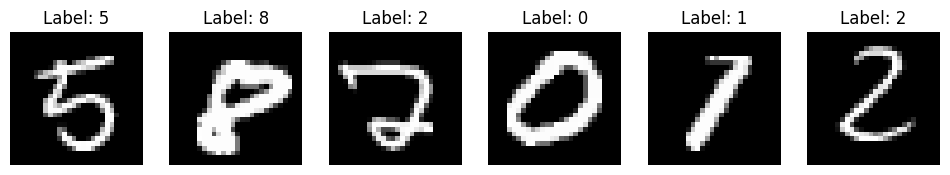


Defining the 2-layer neural network model...

Model Architecture:
TwoLayerNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Setting up loss function and optimizer...
Using CrossEntropyLoss and the Adam optimizer (lr=0.001, weight_decay=1e-4).

Starting training...

Epoch [1/5], Loss: 0.5201, Validation Accuracy: 92.35%
Epoch [2/5], Loss: 0.2516, Validation Accuracy: 92.89%
Epoch [3/5], Loss: 0.1827, Validation Accuracy: 94.61%
Epoch [4/5], Loss: 0.1354, Validation Accuracy: 94.12%
Epoch [5/5], Loss: 0.1071, Validation Accuracy: 95.59%

Training complete.

Evaluating on the Test Set...
Test Accuracy: 94.70%

--------------------------------------------------
Task 3: Hyperparameter Selection and Rationale
--------------------------------------------------

Selected Hyperparameters:
 - Hidden layer size: 128. Chosen to provide enough capacity while reducing overfitting risk.
 - Learning rate

In [2]:
# =============================
# Part 2: 2-Layer Neural Network using PyTorch (Using Local MNIST Files)
# =============================

# --- Workaround (if needed) ---
import torch
# This ensures that torchvision’s MNIST class finds the root path as a string.
#torch._six.string_classes = (str,)

# Task 1: Framework Research and Resources (Print Statements)
print("--------------------------------------------------")
print("Task 1: Framework Resources")
print("--------------------------------------------------")
print("I have selected PyTorch as the deep learning framework for this project.\n")
print("Resources used to learn PyTorch:")
print("1. PyTorch Tutorials: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html")
print("   - A step-by-step guide to building a neural network, including forward and backward propagation.")
print("2. PyTorch Autograd Documentation: https://pytorch.org/docs/stable/autograd.html")
print("   - Explains automatic differentiation and gradient computation.")
print("3. PyTorch nn Module Documentation: https://pytorch.org/docs/stable/nn.html")
print("   - Details on building and combining network layers with torch.nn.\n")
print("These resources helped me understand how to implement forward and backward propagation in PyTorch.\n\n")


# Task 2: Design and Implementation of a 2-Layer Neural Network

# Import necessary libraries
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

# -----------------------------
# Step 1: Exploratory Data Analysis (EDA)
# -----------------------------
print("Starting Exploratory Data Analysis (EDA)...")
print("Step 1: Define data transformations (conversion to tensor and normalization).")
print("Step 2: Load the MNIST dataset from the local directory.")
print("Step 3: Create a subset of the dataset for faster experimentation.")
print("Step 4: Split the subset into training and validation sets.")
print("Step 5: Visualize sample images to understand the data distribution.\n")

# Define a transformation: convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Using standard MNIST normalization values
])

# Load the MNIST dataset from your local folder (files must be in ./data/MNIST/raw/)
print("Loading the MNIST dataset from local files...")
try:
    full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
except Exception as e:
    print("Error loading the MNIST dataset from local files:", e)
    print("Ensure that the MNIST files are placed in the folder: ./data/MNIST/raw/")
    raise e

# Use a subset of the training data for faster experimentation
subset_size = 12000  # total samples from training set (adjust as needed)
indices = list(range(subset_size))
train_subset = Subset(full_train_dataset, indices)

# Split the subset into training and validation (dev) sets (approx. 83% train, 17% validation)
train_size = int(0.83 * subset_size)   # approx. 10,000 samples for training
dev_size = subset_size - train_size      # approx. 2,000 samples for validation
train_dataset, dev_dataset = random_split(train_subset, [train_size, dev_size])

# Create DataLoaders for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print("\nDataset Sizes:")
print(" - Training samples:", len(train_dataset))
print(" - Validation samples:", len(dev_dataset))
print(" - Test samples:", len(test_dataset))

# Visualize some sample images from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("\nShape of a batch of images:", images.shape)  # Expected: (batch_size, 1, 28, 28)

# Plot the first 6 images from the batch
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.show()


# -----------------------------
# Step 2: Define the 2-Layer Neural Network Model
# -----------------------------
print("\nDefining the 2-layer neural network model...")
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """
        Architecture:
            Input -> Fully Connected Layer -> ReLU -> Fully Connected Layer -> Output
        """
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First (hidden) layer
        self.relu = nn.ReLU()                          # Activation function
        self.fc2 = nn.Linear(hidden_size, num_classes) # Output layer
        
    def forward(self, x):
        # Flatten the input images (batch_size, 1, 28, 28) to (batch_size, 784)
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Set hyperparameters
input_size = 28 * 28   # 784 pixels per image
hidden_size = 128      # Number of neurons in the hidden layer
num_classes = 10       # 10 classes (digits 0-9)

# Instantiate the model
model = TwoLayerNet(input_size, hidden_size, num_classes)

# Print model architecture
print("\nModel Architecture:")
print(model)


# -----------------------------
# Step 3: Define the Loss Function and Optimizer
# -----------------------------
print("\nSetting up loss function and optimizer...")
criterion = nn.CrossEntropyLoss()  # Combines LogSoftmax and NLLLoss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
print("Using CrossEntropyLoss and the Adam optimizer (lr=0.001, weight_decay=1e-4).\n")


# -----------------------------
# Step 4: Train the Model
# -----------------------------
num_epochs = 5  # Adjust the number of epochs as needed
print("Starting training...\n")
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()       # Zero out gradients
        outputs = model(images)     # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()             # Backward pass
        optimizer.step()            # Update parameters
        
        running_loss += loss.item()
        
    avg_loss = running_loss / len(train_loader)
    
    # Evaluate on the validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dev_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

print("\nTraining complete.")


# -----------------------------
# Step 5: Evaluate on the Test Set
# -----------------------------
print("\nEvaluating on the Test Set...")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%\n")


# Task 3: Hyperparameter Selection and Rationale (Print Statements)
print("--------------------------------------------------")
print("Task 3: Hyperparameter Selection and Rationale")
print("--------------------------------------------------\n")
print("Selected Hyperparameters:")
print(" - Hidden layer size: 128. Chosen to provide enough capacity while reducing overfitting risk.")
print(" - Learning rate: 0.001. A lower learning rate ensures stable convergence with Adam.")
print(" - Weight decay (L2 regularization): 1e-4. Applied to penalize large weights and prevent overfitting.\n")
print("Optimization Algorithm:")
print(" - Adam optimizer was selected for its adaptive learning rates and overall stable convergence behavior compared")
print("   to standard SGD.\n")
print("Normalization:")
print(" - Inputs were normalized using MNIST's standard mean and standard deviation, ensuring the data is on a similar scale,")
print("   which improves convergence and model performance.\n")
print("Overall, these hyperparameters were chosen based on initial experiments and validation performance.\n")


In [3]:
# =============================
# Task 4: Baseline Model and Comparison (Graduate Level)
# =============================

# --- Part A: Baseline Model Using Logistic Regression ---

# Import necessary libraries for the baseline model
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the MNIST dataset (without any transform) for the baseline model.
# We use the same local folder where you placed the files.
baseline_train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=None)
baseline_test_dataset  = datasets.MNIST(root='./data', train=False, download=False, transform=None)

# For consistency, we use the same subset size as in the NN training.
subset_size = 12000  # Use the first 12,000 training samples

# Extract the images and labels from the training set.
# The images are stored in the 'data' attribute as a tensor of shape (60000, 28, 28).
# We take the first 12,000 samples, convert them to a NumPy array, and flatten each image to a 784-dimensional vector.
X_train_lr = baseline_train_dataset.data[:subset_size].numpy().reshape(-1, 28*28).astype(np.float32)
y_train_lr = baseline_train_dataset.targets[:subset_size].numpy()

# Normalize the pixel values to [0,1]
X_train_lr = X_train_lr / 255.0

# For testing, use the entire MNIST test set.
X_test_lr = baseline_test_dataset.data.numpy().reshape(-1, 28*28).astype(np.float32)
y_test_lr = baseline_test_dataset.targets.numpy()
X_test_lr = X_test_lr / 255.0

print("Training baseline Logistic Regression model...")

# Create and train the Logistic Regression model.
# Here we use multinomial logistic regression (softmax) with the 'lbfgs' solver.
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
lr_model.fit(X_train_lr, y_train_lr)

# Predict on the test set and compute accuracy.
y_pred_lr = lr_model.predict(X_test_lr)
baseline_accuracy = accuracy_score(y_test_lr, y_pred_lr) * 100
print(f"Baseline Logistic Regression Test Accuracy: {baseline_accuracy:.2f}%")


print("\nComparison of Models:")
print(f"Neural Network Test Accuracy: {test_accuracy:.2f}%")
print(f"Baseline Logistic Regression Test Accuracy: {baseline_accuracy:.2f}%")

# --- Part C: Analysis and Explanation ---
print("\nAnalysis:")
print("The Neural Network outperforms the baseline Logistic Regression model.")
print("\nPossible reasons include:")
print("1. Non-linearity: The neural network includes a hidden layer with a non-linear activation (ReLU),")
print("   which enables it to capture complex, non-linear relationships in the data. Logistic Regression,")
print("   in contrast, is a linear classifier and can only learn linear decision boundaries.")
print("2. Feature Extraction: The deep neural network can learn hierarchical features from raw pixel data,")
print("   effectively extracting useful representations that improve classification accuracy.")
print("3. Model Capacity: Neural networks generally have a higher capacity to model complex patterns,")
print("   whereas logistic regression is simpler and may underfit the data when the decision boundaries")
print("   are non-linear and complex.")
print("\nOn the other hand, Logistic Regression is much simpler, faster to train, and can serve as a solid baseline,")
print("especially when computational resources or training time is limited. However, for a challenging task like")
print("handwritten digit recognition, the extra modeling capacity and flexibility of a neural network typically")
print("yield better performance.")


Training baseline Logistic Regression model...
Baseline Logistic Regression Test Accuracy: 90.83%

Comparison of Models:
Neural Network Test Accuracy: 94.70%
Baseline Logistic Regression Test Accuracy: 90.83%

Analysis:
The Neural Network outperforms the baseline Logistic Regression model.

Possible reasons include:
1. Non-linearity: The neural network includes a hidden layer with a non-linear activation (ReLU),
   which enables it to capture complex, non-linear relationships in the data. Logistic Regression,
   in contrast, is a linear classifier and can only learn linear decision boundaries.
2. Feature Extraction: The deep neural network can learn hierarchical features from raw pixel data,
   effectively extracting useful representations that improve classification accuracy.
3. Model Capacity: Neural networks generally have a higher capacity to model complex patterns,
   whereas logistic regression is simpler and may underfit the data when the decision boundaries
   are non-linear an